# Обучение `Deep Q-Network` для задачи `Pong`

Ноутбук полностью основан на:
https://github.com/yandexdataschool/Practical_RL/blob/master/week04_approx_rl/homework_pytorch_main.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!nvidia-smi 

In [ ]:
import sys, os
if not os.path.exists('.setup_complete'):
    !wget -q https://bitbucket.org/ulaelfray/pong/raw/HEAD/atari_wrappers.py
    !wget -q https://bitbucket.org/ulaelfray/pong/raw/HEAD/utils.py
    !wget -q https://bitbucket.org/ulaelfray/pong/raw/HEAD/replay_buffer.py
    !wget -q https://bitbucket.org/ulaelfray/pong/raw/HEAD/framebuffer.py
    !wget -q https://bitbucket.org/ulaelfray/pong/raw/HEAD/common.py

    !touch .setup_complete

In [ ]:
TMP_PATH ='/content/drive/My Drive/tmp'
os.makedirs(TMP_PATH, exist_ok=True)

STATE_DICT_PATH = os.path.join(TMP_PATH, 'agent_state_dict.pth')
MEAN_REWARD_HISTORY_PATH = os.path.join(TMP_PATH, 'mean_reward_history.txt')

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import gym
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output

import common
import utils
from replay_buffer import ReplayBuffer

%matplotlib inline

In [ ]:
ENV_NAME = "PongNoFrameskip-v4"

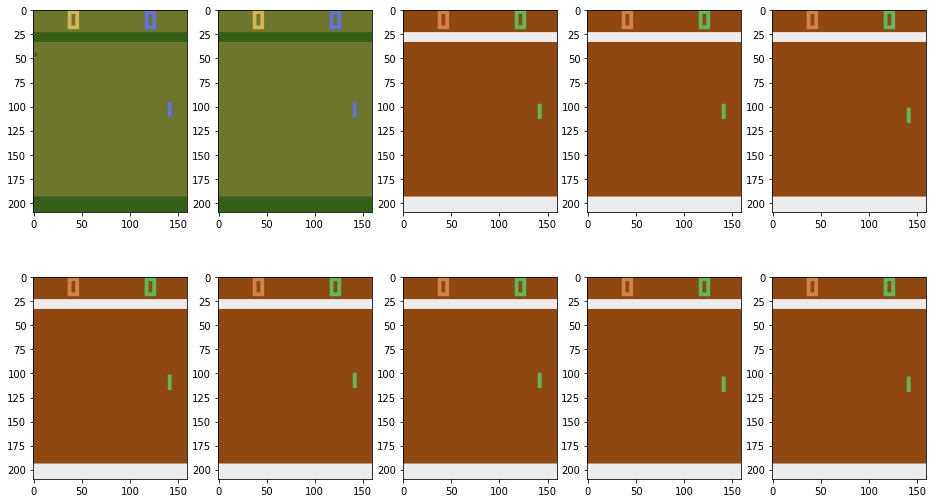

In [ ]:
env = gym.make(ENV_NAME)
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

In [ ]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    #<YOUR CODE>
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        next_state, reward, done, _ = env.step(action)
        exp_replay.add(s, action, reward, next_state, done)
        sum_rewards += reward
        
        if done:
            s = env.reset()
        else:
            s = next_state

    return sum_rewards, s

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=DEVICE):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    # compute V*(next_states) using predicted next q-values
    next_state_values = torch.max(predicted_next_qvalues, dim=1)[0] #<YOUR CODE>

    assert next_state_values.dim(
    ) == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done #<YOUR CODE>

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim(
        ) == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

In [ ]:
seed = 0 #<YOUR CODE: your favourite random seed>
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

env = common.make_env(ENV_NAME, seed=seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n

agent = common.DQNAgent(state_shape, n_actions, epsilon=1).to(DEVICE)
target_network = common.DQNAgent(state_shape, n_actions).to(DEVICE)

In [ ]:
BUFFER_SIZE = 10000

state = env.reset()
exp_replay = ReplayBuffer(BUFFER_SIZE)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
             )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == BUFFER_SIZE:
        break
print(len(exp_replay))

10000


In [ ]:
TIMESTEPS_PER_EPOCH = 1
BATCH_SIZE = 32
TOTAL_STEPS = 3 * 10 ** 6
DECAY_STEPS = 10 ** 6

INIT_EPSILON = 1
FINAL_EPSILON = 0.01

LOSS_FREQ = 50
REFRESH_TARGET_NETWORK_FREQ = 1000
EVAL_FREQ = 5000

MAX_GRAD_NORM = 50

N_GAMES = 30
GAMMA = 0.99

In [ ]:
opt = torch.optim.Adam(agent.parameters(), lr=1e-4)
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []
step = 0

buffer size = 10000, epsilon = 0.82675


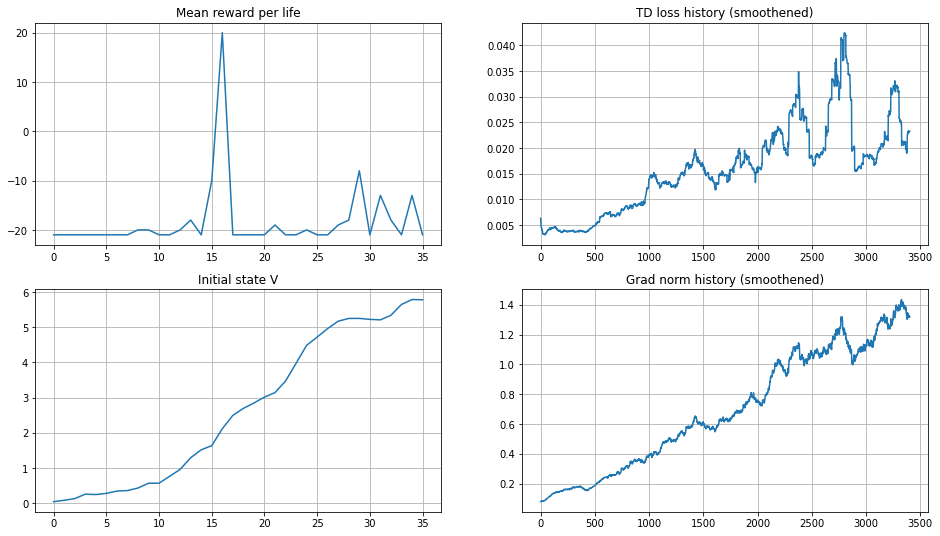

  6%|▌         | 179997/3000001 [8:02:43<12:06:28, 64.70it/s]

KeyboardInterrupt: ignored

In [ ]:
state = env.reset()
for step in trange(step, TOTAL_STEPS + 1):
    if not utils.is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everythin is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(INIT_EPSILON, FINAL_EPSILON, step, DECAY_STEPS)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, TIMESTEPS_PER_EPOCH)

    # train
    #<YOUR CODE: sample batch_size of data from experience replay>
    obs_batch, act_batch, rew_batch, next_obs_batch, done_mask = exp_replay.sample(BATCH_SIZE)

    loss = compute_td_loss(obs_batch, act_batch, rew_batch, next_obs_batch, done_mask,
                       agent, target_network, gamma=GAMMA) #<YOUR CODE: compute TD loss>

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), MAX_GRAD_NORM)
    opt.step()
    opt.zero_grad()

    if step % LOSS_FREQ == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm)

    if step % REFRESH_TARGET_NETWORK_FREQ == 0:
        # Load agent weights into target_network
        #<YOUR CODE>
        target_network.load_state_dict(agent.state_dict())

    if step % EVAL_FREQ == 0:
        mean_rw_history.append(common.evaluate(
            common.make_env(ENV_NAME, clip_rewards=True, seed=step), agent, n_games=N_GAMES, greedy=True)
        )

        with open(MEAN_REWARD_HISTORY_PATH, 'w') as file_obj:
            print(' '.join(str(x) for x in mean_rw_history), file=file_obj)
        
        if max(mean_rw_history) == mean_rw_history[-1]:
            torch.save(agent.state_dict(), STATE_DICT_PATH)
        
        initial_state_q_values = agent.get_qvalues(
            [common.make_env(ENV_NAME, seed=step).reset()]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward per life")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        plt.show()